# Experimenting with real-world images

## Getting the data

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

--2020-08-23 19:35:47--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2800:3f0:4001:812::2010, 2800:3f0:4001:805::2010, 2800:3f0:4001:806::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2800:3f0:4001:812::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  1.67MB/s    in 87s     

2020-08-23 19:37:15 (1.65 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



In [2]:
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()

In [3]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

In [4]:
#Filenames in the horses and humans training directories
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

['horse01-0.png', 'horse01-1.png', 'horse01-2.png', 'horse01-3.png', 'horse01-4.png', 'horse01-5.png', 'horse01-6.png', 'horse01-7.png', 'horse01-8.png', 'horse01-9.png']
['human01-00.png', 'human01-01.png', 'human01-02.png', 'human01-03.png', 'human01-04.png', 'human01-05.png', 'human01-06.png', 'human01-07.png', 'human01-08.png', 'human01-09.png']


In [5]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

total training horse images: 500
total training human images: 527


In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 10

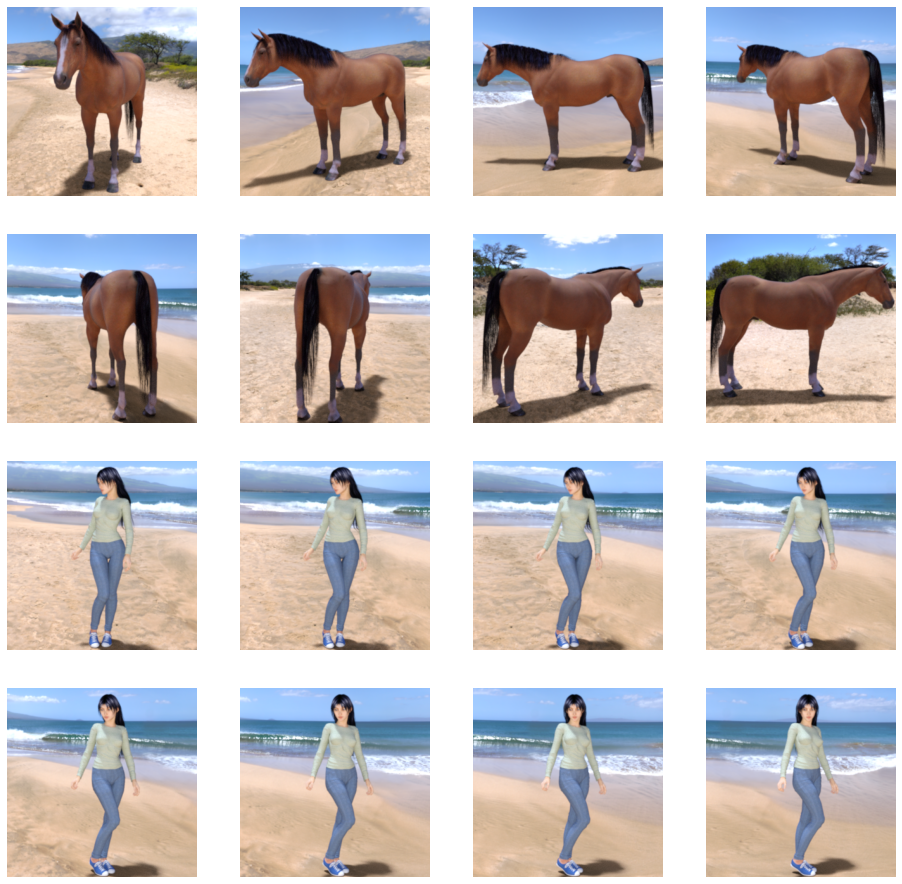

In [11]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pic = [os.path.join(train_horse_dir, file_name) 
                  for file_name in train_horse_names[pic_index - 8:pic_index]]
next_human_pic = [os.path.join(train_human_dir, file_name) 
                  for file_name in train_human_names[pic_index - 8:pic_index]]

for i, img_path in enumerate(next_horse_pic + next_human_pic):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

## Building Model from Scratch

In [12]:
import tensorflow as tf

In [13]:
model = tf.keras.models.Sequential([# Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

In [15]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

### Data Preprocessing

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.


### Training

In [19]:
hisotry = model.fit(train_generator,
                    steps_per_epoch=8,
                    epochs=15,
                    verbose=1)

Epoch 1/15
8/8 [==============================] - 61s 8s/step - loss: 0.6863 - accuracy: 0.5684
Epoch 2/15
8/8 [==============================] - 57s 7s/step - loss: 0.5429 - accuracy: 0.7742
Epoch 3/15
8/8 [==============================] - 60s 8s/step - loss: 0.8535 - accuracy: 0.7408
Epoch 4/15
8/8 [==============================] - 70s 9s/step - loss: 0.3484 - accuracy: 0.8509
Epoch 5/15
8/8 [==============================] - 68s 8s/step - loss: 0.2606 - accuracy: 0.8994
Epoch 6/15
8/8 [==============================] - 61s 8s/step - loss: 0.5202 - accuracy: 0.8354
Epoch 7/15
8/8 [==============================] - 70s 9s/step - loss: 0.1031 - accuracy: 0.9580
Epoch 8/15
8/8 [==============================] - 69s 9s/step - loss: 0.1263 - accuracy: 0.9511
Epoch 9/15
8/8 [==============================] - 65s 8s/step - loss: 0.0439 - accuracy: 0.9867
Epoch 10/15
8/8 [==============================] - 72s 9s/step - loss: 1.3330 - accuracy: 0.8604
Epoch 11/15
8/8 [======================

### Running the Model

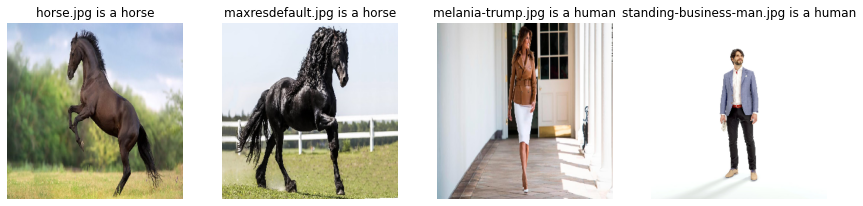

In [75]:
import numpy as np
from keras.preprocessing import image

fig, axarr = plt.subplots(1, 4, figsize=(12, 8))
fig.tight_layout(pad=0.5)
path = os.path.join('/tmp/validation_images')
for i, fn in enumerate(os.listdir(path)):
    img = image.load_img(path + '/' + fn, target_size=(300,300))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    axarr[i].imshow(img)
    if classes[0]>0.5:
        axarr[i].set_title(fn + " is a human")
    else:
        axarr[i].set_title(fn + " is a horse")
    axarr[i].axis('off')

### Visualizing Intermediate Representations

In [107]:
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.inputs, outputs = successive_outputs)
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300,300))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

x /= 255

successive_feature_maps = visualization_model.predict(x)

layer_names = [layer.name for layer in model.layers]

for layer_name, feature_map in  zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        # The feature map has shape (1, size, size, n_features)
        n_features = feature_map.shape[-1] # number of features in feature map
        size = feature_map.shape[1] # feature map size
        # Tiling the images in this matrix
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            # Postprocess the feature to make it visually palatable
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [194]:
feature_map = successive_feature_maps[0]
n_features = feature_map.shape[-1]
size = feature_map.shape[1]
display_grid = np.zeros((size, size * n_features))
x = feature_map[0, :, :, 0]

In [195]:
display_grid[:, 0 * size : (0 + 1) * size] = x

In [196]:
print(display_grid)

[[1.04351985 1.05078864 1.06367326 ... 0.         0.         0.        ]
 [1.05949736 1.06620526 1.06570733 ... 0.         0.         0.        ]
 [1.06563556 1.0706507  1.06385255 ... 0.         0.         0.        ]
 ...
 [0.93773651 0.93920118 0.94093525 ... 0.         0.         0.        ]
 [0.92109859 0.92001224 0.92967677 ... 0.         0.         0.        ]
 [0.91082484 0.90459698 0.9162274  ... 0.         0.         0.        ]]
